# Deconvolution of Control and Relapse Samples

## Where the data at?

In [2]:
input_path = '../Data/Processed_Data/'
output_path = '../Data/Processed_Data/Cell_Deconvolution/'

## Load Data

We will start by loading the mC ARIC deconvolution data.

In [3]:
import pandas as pd

x = pd.read_pickle(input_path+'x.pkl')
y = pd.read_csv(input_path+'y.csv', index_col=0)

# Read deconvolution results
deconv = pd.read_csv(output_path+'Results_TrainData_ARIC.csv', index_col=0)
deconv_test = pd.read_csv(output_path+'Results_TestData_ARIC.csv', index_col=0)

ctrl_rel = pd.read_pickle(input_path+'control_relapse.pkl')

ctrl_rel_x = ctrl_rel[x.columns]
ctrl_rel_y = ctrl_rel[y.columns]

# Split train and test by clinical trial
y_train = y[~y['Clinical Trial'].isin(['AML02', 'AML08'])]
y_test = y[y['Clinical Trial'].isin(['AML02', 'AML08'])]

# Select samples in x that are in y_train
x_train = x.loc[y_train.index]
x_test = x.loc[y_test.index]

# Combine x_train and crtl_rel_x
x_train = pd.concat([x_train, ctrl_rel_x], axis=0)
y_train = pd.concat([y_train, ctrl_rel_y], axis=0)

## Batch Correction with pyCombat

- __pyCombat__: a Python tool for batch effects correction in high-throughput molecular data using empirical Bayes methods

- __Github__: [https://epigenelabs.github.io/pyComBat/](https://epigenelabs.github.io/pyComBat/)

- __Implementation Paper__: [bioRxiv](https://doi.org/10.1101/2020.03.17.995431)

- __Original Paper__: [Biostatistics](https://pubmed.ncbi.nlm.nih.gov/16632515/)

In [4]:
from combat.pycombat import pycombat

# Correct batch effects in the training dataset
x_train2 = pycombat(x_train.T, y_train['Batch']).T

print('Succesfully corrected batch effects in the training dataset.')


Found 4 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Succesfully corrected batch effects in the training dataset.


In [5]:
x_train3 = x_train2.loc[ctrl_rel_x.index]

## Load Reference Dataset

- __FlowSorted.Blood.EPIC__: An optimized library for reference-based deconvolution of whole-blood biospecimens, __n=49__

- __GEO__: [GSE110554](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE110554)

- __PMID__: [29843789](https://www.ncbi.nlm.nih.gov/pubmed/29843789)

- __Description__:  Bisulphite converted DNA from neutrophils (Neu, n=6), monocytes (Mono, n=6), B-lymphocytes (Bcells, n=6), CD4+ T-cells (CD4T, n=7, six samples and one technical replicate), CD8+ T-cells (CD8T, n=6), Natural Killer cells (NK, n=6), and 12 DNA artificial mixtures (labeled as MIX in the dataset) were hybridised to the Illumina Infinium HumanMethylationEPIC Beadchip v1.0_B4

- __External Validation__: [Significant variation in the performance of DNA methylation predictors across data preprocessing and normalization strategies](https://pubmed.ncbi.nlm.nih.gov/36280888/)

- __CSV file__: [Download](https://static-content.springer.com/esm/art%3A10.1186%2Fs13059-018-1448-7/MediaObjects/13059_2018_1448_MOESM4_ESM.csv)

In [6]:
ref = pd.read_pickle(output_path+'paper_defined_immune_reference.pkl')
# remove index name
ref.index.name = None
# remove duplicates from index
ref = ref[~ref.index.duplicated(keep='first')]

# Harmonize index of reference data with our data
merge = ref.join(x.T, how='inner')

# update ref and mix with merge index
ref = ref.loc[merge.index]
mix = x_train3.T.loc[merge.index]

# save ref and mix to csv
ref.to_csv(output_path+'ReferenceData_ARIC.csv')
mix.to_csv(output_path+'Input_Control_Relapse_ARIC.csv')


## Immune Cell Deconvolution with ARIC

- __ARIC__: Accurate and robust inference of cell type proportions from bulk gene expression or DNA methylation data

- __Website__: [xwanglabthu.github.io/ARIC/](xwanglabthu.github.io/ARIC/)

- __PMID__: [34472588](https://pubmed.ncbi.nlm.nih.gov/34472588/)

- __External Validation__: [A systematic assessment of cell type deconvolution algorithms for DNA methylation data](https://doi.org/10.1093/bib/bbac449)

In [8]:
from ARIC import *

# Run cell deconvolution on train data
ARIC(mix_path=output_path+'Input_Control_Relapse_ARIC.csv',
     ref_path=output_path+'ReferenceData_ARIC.csv',
     is_methylation=True,
     confidence=0.75,
     scale=1,
     delcol_factor=15,
     unknown=False,
     save_path=output_path+'Results_Control_Relapse_ARIC.csv')

---------------------------------------------
--------------WELCOME TO ARIC----------------
---------------------------------------------
Data reading finished!
ARIC Engines Start, Please Wait......


100%|██████████| 395/395 [01:43<00:00,  3.83it/s]

Deconvo Results Saving!
Finished!


## Visualize Deconvolution Results

In [9]:
# Import Plotting Functions
from FM_Functions.Data_Visualization import *
sns.set_theme(style="white")

In [10]:
# Read deconvolution results
deconv = pd.read_csv(output_path+'Results_TrainData_ARIC.csv', index_col=0)
deconv_test = pd.read_csv(output_path+'Results_TestData_ARIC.csv', index_col=0)
deconv_ctrl_rel = pd.read_csv(output_path+'Results_Control_Relapse_ARIC.csv', index_col=0)

In [11]:
ctrl_y = ctrl_rel_y[ctrl_rel_y['Sample Type'].isin(['Bone Marrow Normal'])]
rel_y = ctrl_rel_y[~ctrl_rel_y['Sample Type'].isin(['Bone Marrow Normal'])]

ctrl = deconv_ctrl_rel[ctrl_y.index]
rel = deconv_ctrl_rel[rel_y.index]

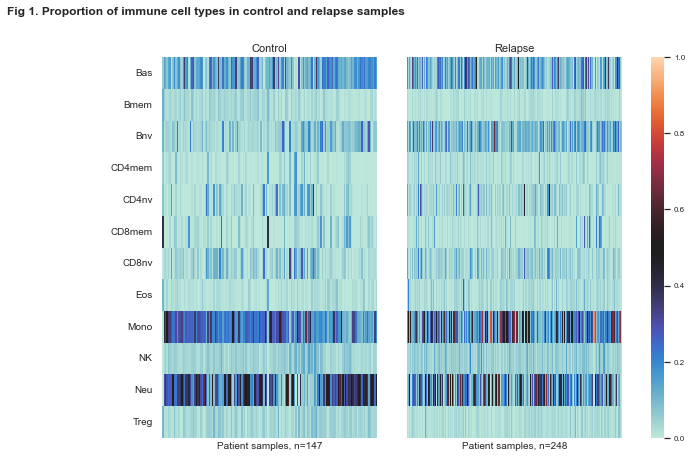

In [14]:
sns.set_theme(style="white")
ctrl.index.name = None
rel.index.name = None
draw_heatmaps(fig_title = 'Proportion of immune cell types in control and relapse samples',
            t2='Relapse', t1= 'Control',
            df2 = rel, df1 = ctrl,
            save_plot=True, fig_number=1, figsize=(9,7))


In [31]:
# Concat `ctrl` and `rel` to `deconv_train`
df = pd.concat([ctrl, deconv, rel], axis=1, keys=['Control','Diagnosis','Relapse'], names=['Sample Type'], verify_integrity=True)

In [40]:
df.T.reset_index(level=0).to_excel(output_path+'ImmuneMethyl_Deconvolution_Results_FM.xlsx')